In [1]:
%pylab
import salpyter

Using matplotlib backend: module://matplotlib_inline.backend_inline
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


[None,
 None,
 (0.01, 5000),
 Text(0, 0.5, 'N'),
 Text(0.5, 0, '$M\\,\\left(M_\\odot\\right)$')]

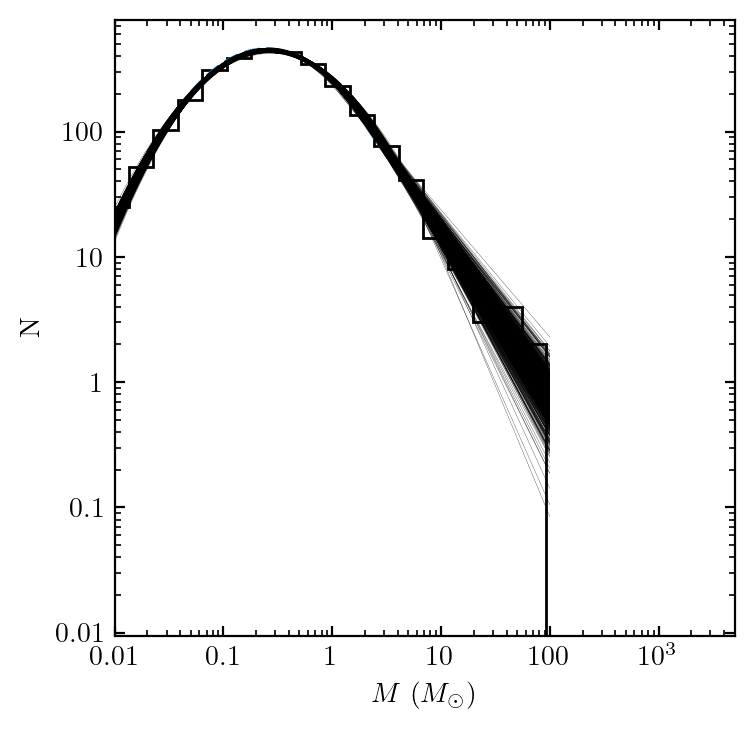

In [8]:
model = "chabrier_smooth" # try out other models by changing the name here
masses = salpyter.imf_samples(10**4,model)
imf_func = salpyter.get_imf_function(model)
p0 = salpyter.imf_default_params(model)


In [ ]:

NUM_HIST_BINS = 31
mbins = np.logspace(-3, 4, 1 + NUM_HIST_BINS)
_, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.hist(masses, mbins, histtype="step", color="black")

mgrid = np.logspace(-3,2,10**4)
imf_to_bins = np.log10(mbins.max() / mbins.min()) / (len(mbins) - 1) * len(masses)


imf_values = imf_func(np.log10(mgrid),p0,logmmin=-3,logmmax=2)
ax.plot(mgrid, imf_to_bins*imf_values,ls='dashed')

samples = salpyter.imf_lnprob_samples(masses, model=model, p0=p0, chainlength=10**3)
for s in samples:
    imf_values = imf_func(np.log10(mgrid),s,logmmin=-3,logmmax=2)
    ax.plot(mgrid, imf_to_bins*imf_values,color='black',lw=0.1)

ax.set(yscale="log",
            xscale="log",
            #xlim=[0.01, 5000],
            #ylim=[0.1, 1000],
            ylabel="N",
            xlabel=r"$M\,\left(M_\odot\right)$",
)


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  3.,  0.,
         0.,  1.,  4.,  3.,  3.,  3.,  1.,  7.,  4.,  3.,  4.,  3.,  3.,
         7.,  3.,  6., 10.,  8., 13., 15., 23., 16., 17., 31., 31., 25.,
        36., 26., 37., 28., 38., 47., 41., 43., 48., 34., 41., 45., 39.,
        47., 39., 27., 20., 23., 22., 14.,  9., 13., 11.,  4.,  1.,  5.,
         3.,  1.,  1.,  2.,  1.,  0.,  0.,  0.,  1.]),
 array([-2.08528215, -2.0745861 , -2.06389006, -2.05319402, -2.04249798,
        -2.03180194, -2.0211059 , -2.01040985, -1.99971381, -1.98901777,
        -1.97832173, -1.96762569, -1.95692965, -1.9462336 , -1.93553756,
        -1.92484152, -1.91414548, -1.90344944, -1.8927534 , -1.88205735,
        -1.87136131, -1.86066527, -1.84996923, -1.83927319, -1.82857715,
        -1.8178811 , -1.80718506, -1.79648902, -1.78579298, -1.775096

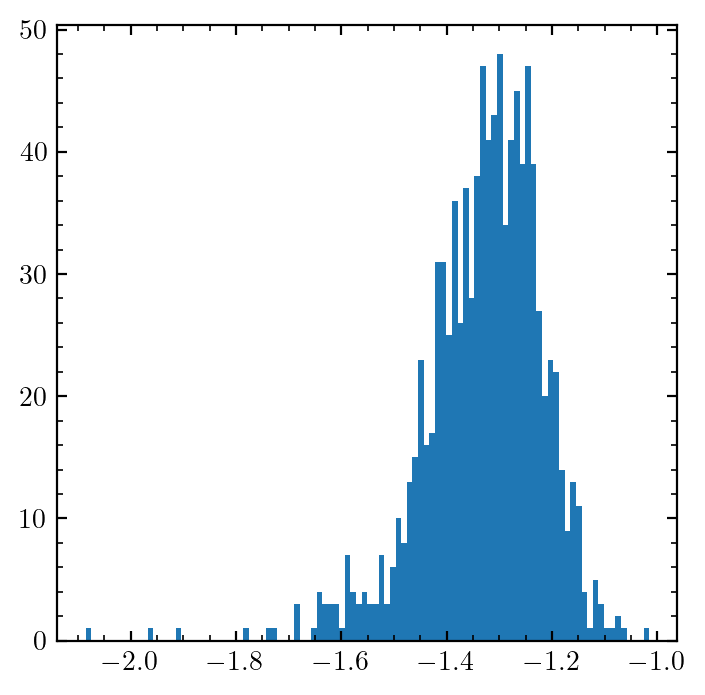

In [10]:
plt.hist(samples[:,2],100)